In [1]:
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from softcvi_validation.tasks.available_tasks import get_available_tasks
from softcvi_validation.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())

plt.style.use('./plots/style.mplstyle')

palette = {
        "SoftCVI(a=0.75)": "#0C5DA5",
        "SoftCVI(a=1)": "#FF9500",
        "SNIS-fKL": "#845B97",
        "ELBO": "#545454",
}

tasks = get_available_tasks()

method_names = list(palette.keys())

In [2]:
metric_names = [
    "mean_log_prob_reference",
    "negative_posterior_mean_l2",
    "coverage_probabilities",
    "run_time",
]

results = {task_name: {method_name: [] for method_name in method_names} for task_name in tasks.keys()}

hyperparam_str="k=8_negative=proposal"

for task_name in tasks.keys():
    for method_name in method_names:
        results_i = []
        for seed in range(20):
            file = f"results/{task_name}/metrics/{method_name}_seed={seed}_{hyperparam_str}.npz"
            try:
                results_i.append(dict(np.load(file)))
            except FileNotFoundError:
                print(f"Missing: {file}")

        results[task_name][method_name] = {
            metric_name: np.stack([run[metric_name] for run in results_i]) for metric_name in metric_names
        }
            

plot_task_names = {
    "eight_schools": "Eight\nSchools",
    "linear_regression": "Linear\nRegression",
    "slcp": "SLCP",
    "garch": "GARCH(1,1)",
}

results = {new: results[old] for old, new in plot_task_names.items()}            

/tmp/ipykernel_52391/1455667463.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


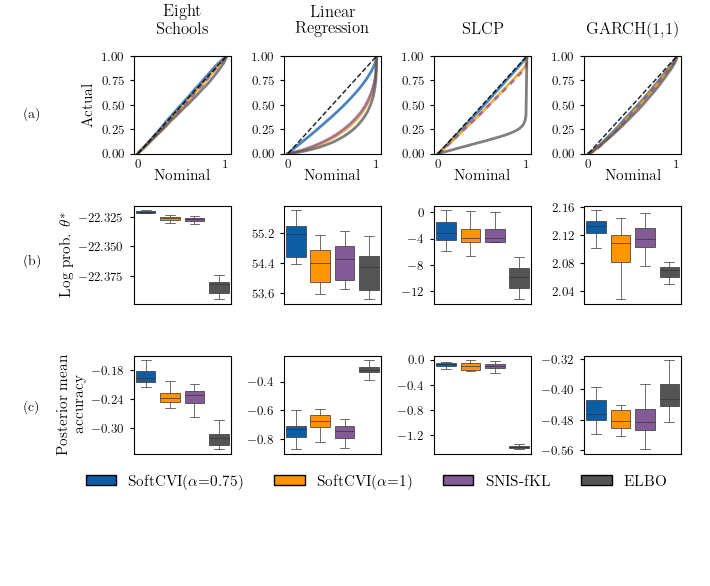

In [5]:
fig = plt.figure(layout='constrained', figsize=(7, 6))
subfigs = fig.subfigures(nrows=len(results), ncols=1)

####### Coverage #######
axes0 = subfigs[0].subplots(ncols=len(tasks.keys()))

nominal_frequency = np.linspace(0, 1, 100)

for (task_name, task_result), ax in zip(results.items(), axes0, strict=False):
    ax.set_title(task_name, y=1.15)
    ax.set_xlabel("Nominal", labelpad=0)
    
    for method in method_names:
        coverage_probs = task_result[method]["coverage_probabilities"]

        make_dashed_if = [  # Overlapping lines
            ("Eight\nSchools", "SNIS-fKL"),
            ("SLCP", "SNIS-fKL"),
            ("GARCH(1,1)", "SNIS-fKL"),
        ]
        if any([task_name==t and method==m for t, m in make_dashed_if]):
            linestyle = (0, (2,2))
        else:
            linestyle="-"

        ax.plot(
            nominal_frequency,
            np.mean(coverage_probs, axis=0),
            color=palette[method],
            alpha=0.75,
            linewidth=2,
            linestyle = linestyle,
            )

    ax.plot([0, 1], [0, 1], color="black", linewidth=1, alpha=0.9,  linestyle="--")
    ax.set_ylim(0,1)
        

####### log prob true #######

axes1 = subfigs[1].subplots(ncols=len(results))

box_kwargs = {
    "showfliers": False,
    "palette": palette,
    "saturation": 1,
    "linewidth": 0.5,
}

for task_result, ax in zip(results.values(), axes1, strict=True):

    df = pd.concat([
        pd.DataFrame({method_name: task_result[method_name]["mean_log_prob_reference"]})
        for method_name in method_names
    ], axis =1)
   
    sns.boxplot(df, ax=ax, **box_kwargs)

### Negative posterior mean l2 ###
axes2 = subfigs[2].subplots(ncols=len(results))

for task_result, ax in zip(results.values(), axes2, strict=True):
    df = pd.concat([
        pd.DataFrame({method_name: task_result[method_name]["negative_posterior_mean_l2"]})
        for method_name in method_names
    ], axis =1)
    sns.boxplot(df, ax=ax, **box_kwargs)
    
axes0[0].set_ylabel("Actual")
axes1[0].set_ylabel(r"Log prob. $\theta^*$")
axes2[0].set_ylabel("Posterior mean \n accuracy")

for axes in [axes0, axes1, axes2]:
    for ax in axes:
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.set_box_aspect(1)
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.tick_params(axis="x", which="major", length=0)

for axes in [axes1, axes2]:
    for ax in axes:
        ax.tick_params("x", bottom=False)
        ax.xaxis.set_ticklabels([])

handles = [
    mpatches.Patch(facecolor=v, label=k.replace("a=", r"$\alpha$="), edgecolor="black")
    for k, v in palette.items()
    ]
fig.legend(
    handles=handles,
    bbox_to_anchor=[0.53, 0.13],
    loc='lower center',
    ncol=len(method_names),
    )

letter_space = 0.303
letter_start_height = 0.34
letter_x_pos = -5
letters = {
    "(a)": (letter_x_pos, letter_start_height),
    "(b)": (letter_x_pos, letter_start_height - letter_space),
    "(c)": (letter_x_pos, letter_start_height - 2*letter_space),
}

for letter, position in letters.items():
    axes[0].annotate(letter, xy=position, annotation_clip=False)
    
plt.tight_layout()
plt.subplots_adjust(
    top = 0.5,
    bottom = -0.15,
    right = 1.05,
    left = 0.1,
    wspace = -0.3,
    )
plt.savefig(f"plots/metrics_{hyperparam_str}.pdf")


### Run times

/tmp/ipykernel_52391/219193739.py:25: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


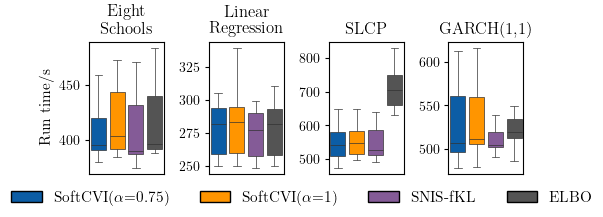

In [4]:
fig = plt.figure(layout='constrained', figsize=(5.15, 2))
axes = fig.subplots(ncols=len(tasks))

for (task_name, task_result), ax in zip(results.items(), axes, strict=True):
    df = pd.concat([
        pd.DataFrame({method_name: task_result[method_name]["run_time"]})
        for method_name in method_names
    ], axis =1)
    sns.boxplot(df, ax=ax, **box_kwargs)
    ax.set_title(task_name.replace("_", "\n")) 

axes[0].set_ylabel("Run time/s")

fig.legend(
    handles=handles,
    bbox_to_anchor=[0.54, -0.15],
    loc='lower center',
    ncol=len(method_names),
    )
    
for ax in axes:
    ax.tick_params("x", bottom=False)
    ax.xaxis.set_ticklabels([])

fig.tight_layout()
fig.savefig(f"plots/run_times_{hyperparam_str}.pdf")
